# Final Project

#### Project: NHL player salary prediction
#### Name: Xueyao Wang

## Executive Summary

This notebook includes preprocessing steps, model selection analysis and conclusion. In the preprocessing, we have removed the 'Country' column, excluded players younger than 21, super earners and features showing weak correlations with salary to eliminate noise from the dataset. We also rescaled our features to prevent any bias due to different feature scales. For model training, we conducted a grid search to find the optimal hyperparameters, aiming to avoid overfitting and underfitting issues. For model selection, we compared the performance of both models using metrics such as MAE, MSE, RMSE, and R^2 and evaluated their ability to capture varying salary levels, which is important for stratifying players and optimizing the team structure. Based on our analysis, SVM outperformed the decision tree model. It will be instrumental in helping the club owners make informed decisions in player contract negotiations and acquisitions. (140 words)

## Preprocessing

In [745]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import utils9
import matplotlib.pyplot as plt
import pickle

In [746]:
# Loading the cleaned data
df = pd.read_csv('cleaned_nhl_data.csv', sep=',').copy()

In [747]:
# Displaying the data
df.head()

,Salary,Cntry,DftYr,DftRd,Ovrl,GP,G,A,A1,A2,...,Grit,DAP,Pace,GS,GS/G,Age,LW,RW,D,C
0,575000.00,CAN,2008,10.00,292.00,1,0,0,0,0,...,0,0.00,126.00,0.30,0.28,28,1,0,0,0
1,5500000.00,USA,2005,2.00,42.00,64,7,14,9,5,...,223,8.00,104.40,16.10,0.26,29,1,1,0,0
2,842500.00,SWE,2012,2.00,37.00,15,1,1,0,1,...,15,7.00,97.60,1.00,0.06,23,1,0,0,0
3,625000.00,USA,2010,5.00,140.00,7,1,2,2,0,...,14,10.00,107.40,4.60,0.66,24,1,0,0,0
4,925000.00,FIN,2015,2.00,35.00,82,24,25,12,13,...,91,7.00,108.80,57.60,0.71,19,1,1,0,0


Based on our initial project, we have identified several preprocessioning steps to improve the predictability of our model:

**1.Irrelevant Column Removal:** Country column is irrelevant to salary prediction, we will drop it.

**2.Exclusion of Players Younger than 21:** Players who are younger than 21 are typically bound to rookie contracts with stable and predictable salaries. Including such players in our dataset may only introduce noise and affect the model's prediction ability. So, we will exclude players who are younger than 21 from our dataset to ensure the model's focus is on relevant data.

**3.Exclusion of Super earners:** Superstars (refering to 7 palyers in our dataset earning more than 1000 millions) in the NHL may earn exceptionally high salaries due to various factors such as sponsorships and business value. It is beyond the scope of performance-based predictions and will increase unnecessary complexity to our model.

**5.Feature Selection based on Correlation:** With 135 features in our dataset, we suspect that some features may be less relevant and may confuse the model. Therefore, we run a correlation analysis and will drop features that show weak correlation (-0.4 < r < 0.4) with salary. This helps reduce noise and improve models’ ability to capture meaningful patterns in the data.

In [748]:
# drop country object column
df.drop(['Cntry'],inplace=True,axis=1)

In [749]:
# drop age <=20
data = df[df['Age']>20]
data.head()

,Salary,DftYr,DftRd,Ovrl,GP,G,A,A1,A2,PTS,...,Grit,DAP,Pace,GS,GS/G,Age,LW,RW,D,C
0,575000.00,2008,10.00,292.00,1,0,0,0,0,0,...,0,0.00,126.00,0.30,0.28,28,1,0,0,0
1,5500000.00,2005,2.00,42.00,64,7,14,9,5,21,...,223,8.00,104.40,16.10,0.26,29,1,1,0,0
2,842500.00,2012,2.00,37.00,15,1,1,0,1,2,...,15,7.00,97.60,1.00,0.06,23,1,0,0,0
3,625000.00,2010,5.00,140.00,7,1,2,2,0,3,...,14,10.00,107.40,4.60,0.66,24,1,0,0,0
5,2800000.00,2007,1.00,5.00,82,3,10,5,5,13,...,295,8.70,105.80,18.50,0.23,28,0,0,1,0


In [750]:
# drop outlier salary >10 million
data = data[data['Salary']<10000000]
data.head()

,Salary,DftYr,DftRd,Ovrl,GP,G,A,A1,A2,PTS,...,Grit,DAP,Pace,GS,GS/G,Age,LW,RW,D,C
0,575000.00,2008,10.00,292.00,1,0,0,0,0,0,...,0,0.00,126.00,0.30,0.28,28,1,0,0,0
1,5500000.00,2005,2.00,42.00,64,7,14,9,5,21,...,223,8.00,104.40,16.10,0.26,29,1,1,0,0
2,842500.00,2012,2.00,37.00,15,1,1,0,1,2,...,15,7.00,97.60,1.00,0.06,23,1,0,0,0
3,625000.00,2010,5.00,140.00,7,1,2,2,0,3,...,14,10.00,107.40,4.60,0.66,24,1,0,0,0
5,2800000.00,2007,1.00,5.00,82,3,10,5,5,13,...,295,8.70,105.80,18.50,0.23,28,0,0,1,0


In [751]:
# drop correlation <0.4 or >-0.4
corr = data.corr()
corr = corr[(-0.4>corr)|(corr>0.4)]['Salary'].dropna()
colume_names = corr.index[1:]
features = data[colume_names]
features.head()

,DftYr,GP,G,A,A1,A2,PTS,Shifts,TOI,TOI/GP,...,TKA,PENT,PEND,OPS,DPS,PS,OTOI,GS,GS/G,Age
0,2008,1,0,0,0,0,0,12,514,8.57,...,1.00,0.00,1.00,0.00,0.00,0.00,42.63,0.30,0.28,28
1,2005,64,7,14,9,5,21,1397,63969,16.65,...,81.00,64.00,74.00,0.10,0.50,0.70,2641.98,16.10,0.26,29
2,2012,15,1,1,0,1,2,256,11102,12.33,...,23.00,13.00,13.00,-0.20,0.10,-0.10,558.17,1.00,0.06,23
3,2010,7,1,2,2,0,3,117,5366,12.78,...,8.00,5.00,3.00,0.20,0.10,0.30,271.29,4.60,0.66,24
5,2007,82,3,10,5,5,13,2095,97371,19.80,...,196.00,92.00,75.00,-0.30,4.80,4.60,3045.60,18.50,0.23,28


Feature scaling will be applied to the dataset to help in achieving better model performance. As we see in the distribution histograms, the features are not normally distributed. For this reason, we will use **MinMaxScaler** to transform the features to a range between zero and one, preventing certain features from dominating others during model training.

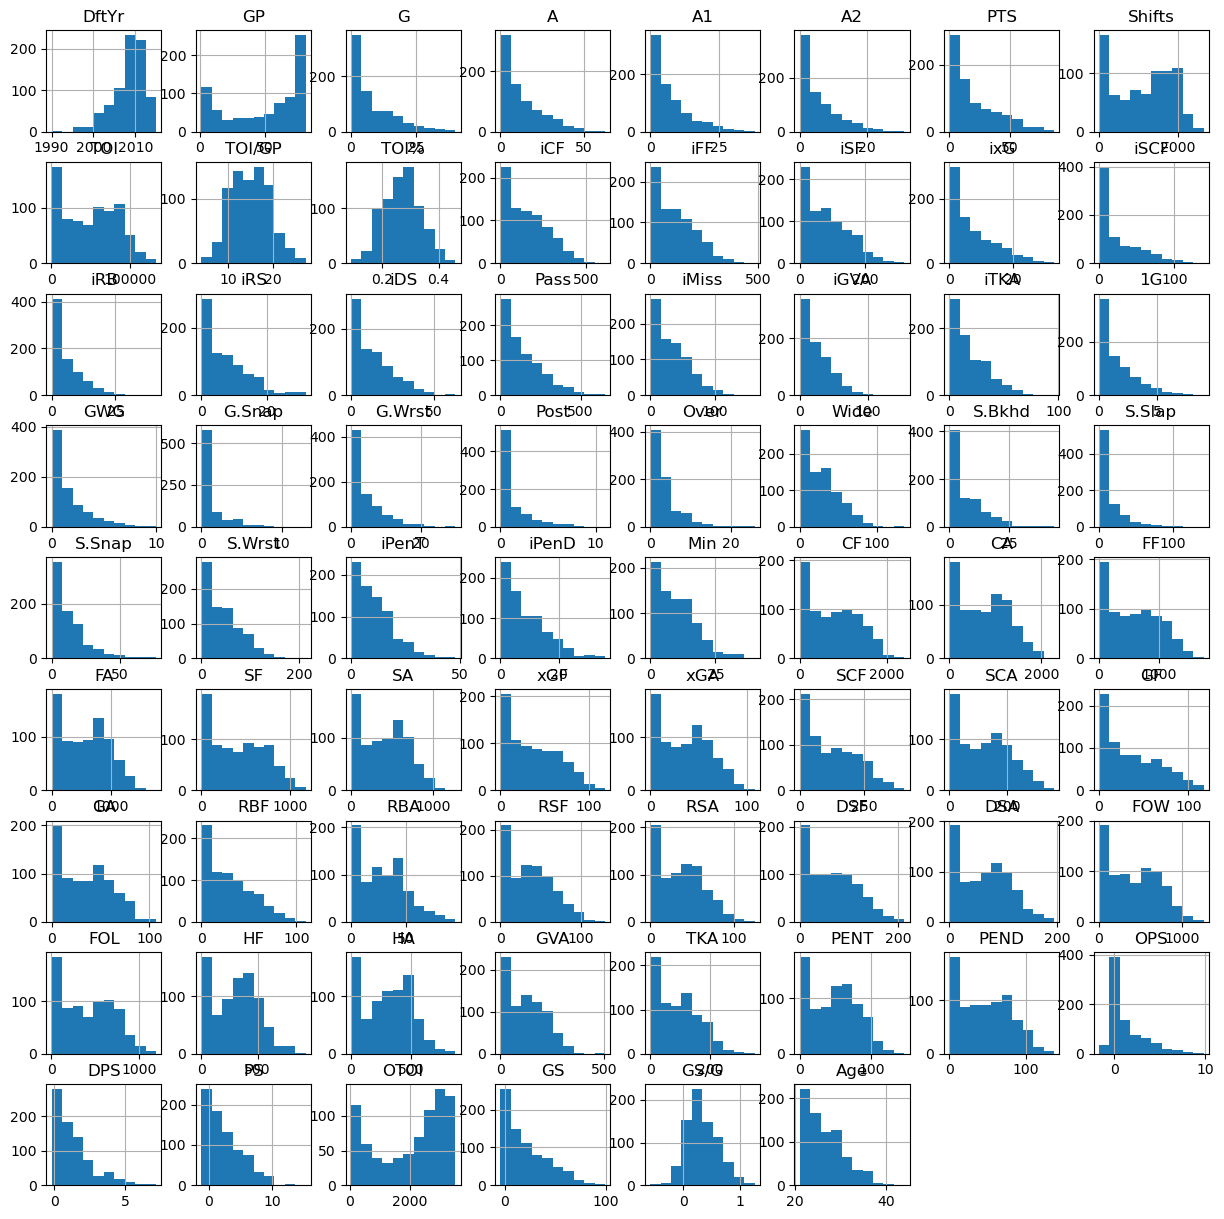

In [752]:
# plot the features to see the distribution
features.hist(figsize=(15,15))
plt.show()

In [753]:
# feature rescaling using MinmaxScaler
min_max_scaled=preprocessing.MinMaxScaler().fit_transform(features)
features=pd.DataFrame(min_max_scaled, columns=features.columns)
features.head()

,DftYr,GP,G,A,A1,A2,PTS,Shifts,TOI,TOI/GP,...,TKA,PENT,PEND,OPS,DPS,PS,OTOI,GS,GS/G,Age
0,0.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,...,0.00,0.00,0.01,0.15,0.03,0.07,0.00,0.04,0.47,0.30
1,0.60,0.78,0.18,0.22,0.24,0.16,0.24,0.52,0.48,0.54,...,0.23,0.44,0.54,0.16,0.09,0.12,0.75,0.20,0.46,0.35
2,0.88,0.17,0.03,0.02,0.00,0.03,0.02,0.09,0.08,0.36,...,0.07,0.09,0.09,0.13,0.04,0.07,0.15,0.05,0.35,0.09
3,0.80,0.07,0.03,0.03,0.05,0.00,0.03,0.04,0.04,0.38,...,0.02,0.03,0.02,0.17,0.04,0.09,0.07,0.09,0.68,0.13
4,0.68,1.00,0.08,0.16,0.13,0.16,0.15,0.79,0.73,0.67,...,0.56,0.63,0.55,0.12,0.68,0.35,0.86,0.22,0.44,0.30


In [754]:
# store labels
labels = data['Salary']
labels

0      575000.00
1     5500000.00
2      842500.00
3      625000.00
5     2800000.00
         ...    
845   3250000.00
846    575000.00
847   4500000.00
848   2000000.00
849    727500.00
Name: Salary, Length: 778, dtype: float64

split the data into training/validation/testing sets using 80%/10%/10% respectively

In [755]:
# split the dataset into training set and another set for validation and testing
# training (80%) / total (100%) = 0.8
features_training, features_vt, label_training, labels_vt = train_test_split(features, labels, test_size=0.2, random_state=20)

# validation (50%) / total (100%) = 0.5 & testing (50%) / total (100%) = 0.5
features_validation, features_testing, label_validation, label_testing = train_test_split(features_vt, labels_vt, test_size=0.5, random_state=20)

In [756]:
# check the training set
features_training.head()

,DftYr,GP,G,A,A1,A2,PTS,Shifts,TOI,TOI/GP,...,TKA,PENT,PEND,OPS,DPS,PS,OTOI,GS,GS/G,Age
416,0.64,1.00,0.58,0.43,0.50,0.26,0.58,0.67,0.63,0.56,...,0.47,0.42,0.55,0.52,0.22,0.42,0.91,0.54,0.66,0.30
618,0.72,0.95,0.03,0.11,0.05,0.16,0.09,0.72,0.63,0.60,...,0.39,0.57,0.50,0.08,0.36,0.18,0.83,0.06,0.33,0.26
63,0.48,0.99,0.03,0.22,0.18,0.23,0.17,0.89,0.82,0.79,...,0.59,0.73,0.54,0.10,0.65,0.32,0.80,0.21,0.43,0.52
611,0.76,0.90,0.15,0.27,0.21,0.29,0.27,0.77,0.73,0.76,...,0.54,0.64,0.50,0.26,0.81,0.50,0.76,0.40,0.59,0.22
391,0.80,0.43,0.15,0.08,0.05,0.10,0.13,0.29,0.27,0.55,...,0.17,0.34,0.20,0.17,0.09,0.12,0.40,0.11,0.43,0.13


In [757]:
# check the length of features sets
print("Length of features:", len(features))
print("Length of features_training set:", len(features_training))
print("Length of features_validation set:", len(features_validation))
print("Length of features_testing set:", len(features_testing))

Length of features: 778
Length of features_training set: 622
Length of features_validation set: 78
Length of features_testing set: 78


In [758]:
# check the length of labels sets
print("Length of labels:", len(labels))
print("Length of labels_training set:", len(label_training))
print("Length of labels_validation set:", len(label_validation))
print("Length of labels_testing set:", len(label_testing))

Length of labels: 778
Length of labels_training set: 622
Length of labels_validation set: 78
Length of labels_testing set: 78


Save the files to pickle for trainng.

In [759]:
# save the features training sets
with open('subsets_ft.pkl', 'wb') as file:
    file.write(pickle.dumps(features_training))


In [760]:
# save the features validation sets
with open('subsets_fv.pkl', 'wb') as file:
    file.write(pickle.dumps(features_validation))

In [761]:
# save the label training sets
with open('subsets_lt.pkl', 'wb') as file:
    file.write(pickle.dumps(label_training))

In [762]:
# save the label validation sets
with open('subsets_lv.pkl', 'wb') as file:
    file.write(pickle.dumps(label_validation))

## Model Selection

In [763]:
# load the decision tree model
with open('model_dt.pkl', 'rb') as file:
    dt = pickle.load(file)
dt

DecisionTreeRegressor(max_depth=5, max_features='auto', random_state=20)

In [772]:
#load the svm model
with open('model_svm.pkl', 'rb') as file:
    svm = pickle.load(file)
svm

SVR(C=2000, gamma=1, kernel='poly')

i. Find predictions using the testing set.

ii. Use the score() function to display the testing coefficient of determination.

iii. Decide which metrics to use in analysis (e.g. absolute error, RMSE, MSE, recall, precision, Fβ score, etc.); calculate them using the testing set and display them. Explain how these metrics will help you decide which model is best.

Since our model is a regression model, we will exclude classification metrics and focus on mainly three metrics in our analysis, namely, mean absolute error (MAE), mean square error (MSE) and root mean square error(RMSE). 

**MAE** measures the average absolute difference between the predicted and actual salaries, so we are expecting a model with a lower MAE. Since it does not square the error, it is less sensitive to outliers compared to MSE and RMSE. 

**MSE** measures the average squared difference between the predicted and actual salaries. We are expecting a model with a lower MSE because it means the predicated salaries are closer to the actual earning. MSE gives higher weight to larger errors, which makes it sensitive to outliers.

Same with **RMSE** which is the square root of MSE, it measures the average error in the same units as the label which makes it easy to interpret. The lower the RMSE, the closer the prediction to the actually earning.

Additionally, we could also consider **R^2** when comparing models, since R^2 provides a measure of how well the model fits our data and help assess the proportion of variability in the label that can be explained by the model. It ranges from 0 to 1, a higher R^2 indicates a better fit of the model to the data. But we need to be aware that a model with a high R^2 value may not necessarily be a good predictor, as it may overfit the data resulting poor prediction on new data.

In a nutshell, since our goal here is to minimize the prediction errors with a disparity of earnings, the metrics like MSE, RMSE may be more appropriate in our case.

In [765]:
# decision tree 
# make predictions using testing set
pred_dt = dt.predict(features_testing).astype(int)

# return the testing coefficient of determination (R^2)
score_dt= dt.score(features_testing, label_testing)

# return the mean absolute error
mae_dt = mean_absolute_error(label_testing, pred_dt).astype(int)

# return the mean squared error
mse_dt = mean_squared_error(label_testing, pred_dt)

# return the root mean squared error
rmse_dt =mean_squared_error(label_testing, pred_dt, squared=False).astype(int) 

In [766]:
# svm
# make predictions using testing set
pred_svm = svm.predict(features_testing).astype(int)

# return the testing coefficient of determination (R^2)
score_svm= svm.score(features_testing, label_testing)

# return the mean absolute error
mae_svm = mean_absolute_error(label_testing, pred_svm).astype(int)

# return the mean squared error
mse_svm = mean_squared_error(label_testing, pred_svm)

# return the root mean squared error
rmse_svm =mean_squared_error(label_testing, pred_svm, squared=False).astype(int) 


In [767]:
# create a dataframe to compare the two models
compare_pred = pd.DataFrame({'Actual': label_testing, 
                             'Predicted DT': pred_dt, 
                             'Predicted SVM': pred_svm})
compare_pred

,Actual,Predicted DT,Predicted SVM
338,4000000.00,4250000,4415848
732,600000.00,857424,877226
391,667500.00,857424,1050728
357,4250000.00,2263333,3396530
228,5500000.00,7154218,6424938
...,...,...,...
212,650000.00,857424,1244096
486,832500.00,857424,617831
521,1750000.00,857424,2404724
9,650000.00,857424,1014938


In [768]:
# create a dataframe to compare the two models
compare_metrics = pd.DataFrame({'R^2': [score_dt, score_svm],
                                'MAE': [mae_dt, mae_svm],
                                'MSE': [mse_dt, mse_svm],
                                'RMSE': [rmse_dt, rmse_svm]}).T
                                
          
compare_metrics.columns = ['Decision Tree', 'SVM']
pd.options.display.float_format = '{:.2f}'.format
compare_metrics

,Decision Tree,SVM
R^2,0.56,0.65
MAE,895933.00,775937.00
MSE,1902134623984.17,1538804425944.96
RMSE,1379178.00,1240485.00


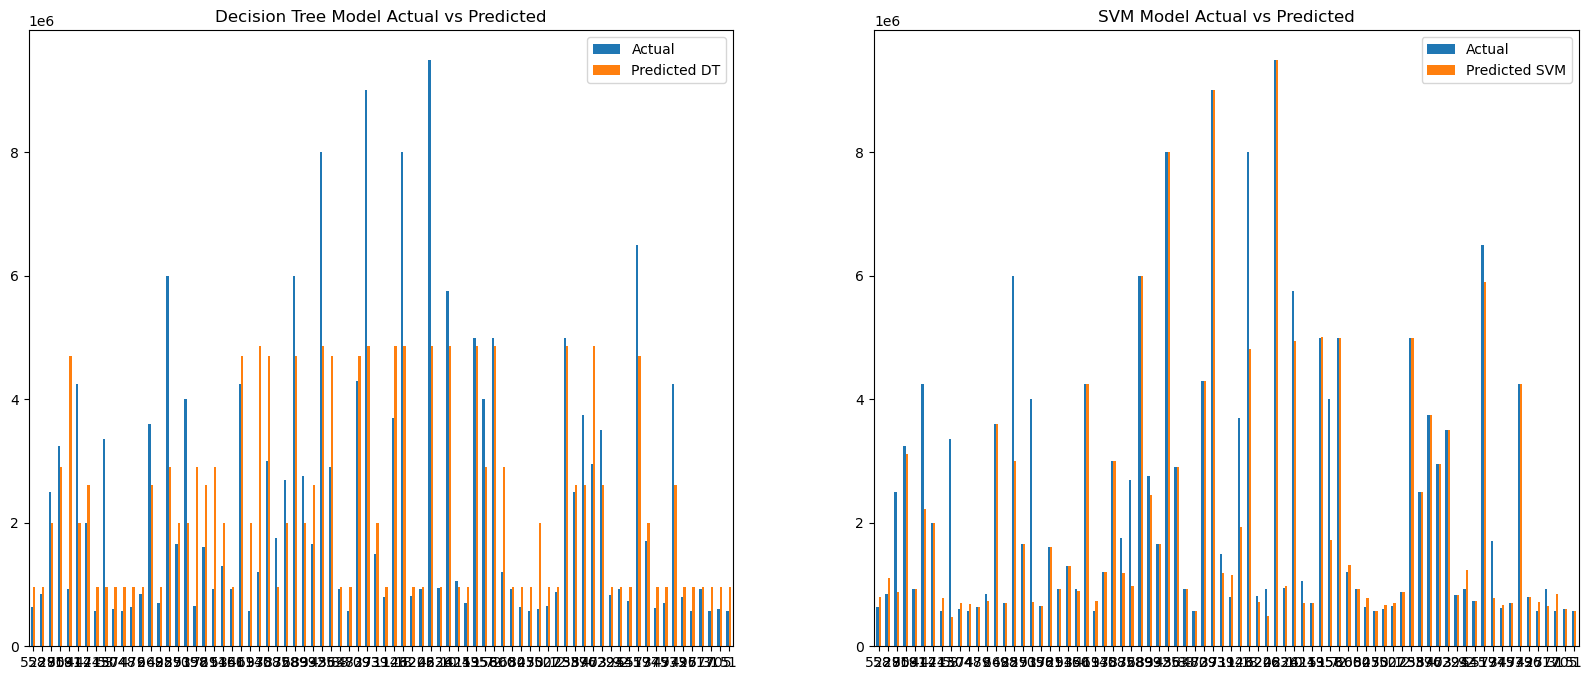

In [769]:
# plot two bar cluster subplot of actual and predicted salary for decision tree and svm models respectively
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# set the xticks for subplots
plt.setp(axes, xticks=[])

# plot the bar cluster for decision tree model
compare[['Actual','Predicted DT']].plot(ax=axes[0], kind='bar')

# set the title for the first subplot
axes[0].title.set_text('Decision Tree Model Actual vs Predicted')

# plot the bar cluster for svm model
compare[['Actual','Predicted SVM']].plot(ax=axes[1], kind='bar')

# set the title for the second subplot
axes[1].title.set_text('SVM Model Actual vs Predicted')

plt.show()


 Select the best model for the use case and justify your choice. 

The best model is **SVM**.

The SVM model seems to be a slightly better model of the two. With a R^2 score of 0.65, the model can explain approximately 65% of the variance in NHL player salaries, which is slightly higher than the performance of the Decision Tree model.

The SVM model also achieved lower values for MAE, MSE, and RMSE, compared to the Decision Tree model. Specifically, the MAE decreased from \\$895,933 to \\$775,937, and the RMSE decreased from \\$1379,178 to \\$1240,485  from the Decision Tree to the SVM model. This suggests that the SVM model's predictions are relatively closer to the actual salaries, indicating more accurate salary estimates.

Furthermore, the SVM model demonstrated better resilience to outliers, as it is capable of finding the optimal hyperplane that maximizes the margin between data points. This enables the model to effectively capture the variation in player salaries, making it more robust in addressing the specific use case of salary allocation in NHL clubs, where there are varying salary levels among players. In contrast, the Decision Tree model with a depth of 5 may be less sensitive to outliers, which could affect its prediction ability in capturing the variability in salaries.

Given these findings, the SVM model appears to be more suitable for our NHL player salary prediction, as evidenced by its lower MAE, MSE, and RMSE values. The insights provided by the model's predictions can inform our decision-making in player contract negotiations and player acquisitions.


## Conclusion

The **SVM** model was chosen and will be used as a tool for our salary allocation decisions in an NHL club. 

The R^2 score of 0.65 indicates that the model can explain approximately 65% of the variance in salaries, and the lower MAE, MSE, and RMSE values suggest that the model's predictions are relatively closer to the actual salaries. The model has been trained on a dataset that includes comprehensive player performance statistics, allowing it to capture moderate complex patterns within the data. 

To avoid overfitting, the model has been carefully tuned during training using the fivefold cross validation to find the best hyperparameters and balance the model's complexity and generalization. The model's performance has been evaluated not only on the training set but also on a validation set to avoid overfitting or underfitting issues.

To ensure the model's robustness in capturing outliers, the model has been trained and validated on a dataset that includes players with varying salary levels. The model demonstrated its ability to effectively capture the variation in player salaries.

The model’s prediction ability can help identify players who provide the best value for their salary and maximize team performance within salary cap constraints. This would lead to better resource management and team performance, ultimately contributing to the overall success of our NHL club.

For future improvement, we can try to incorporate more data from different seasons, as it may capture additional patterns from a diverse data range and may contribute to a better prediction. We can also try other algrithomns such as Random Forests as it can combine more decision trees to capture underlying relationships in the dataset.